In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import Conv2D, RepeatVector, Bidirectional, TimeDistributed, GRU
from keras.utils import to_categorical
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

/home/cxshe/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## settings

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
model_name = './model/model_cnn_rnn'

# img label

In [3]:
df = pd.read_csv('./data/label.csv')
df = df.astype(str)
df['len'] = df['label'].apply(lambda x: len(x))
print('data length:',len(df))
df.head(3)

data length: 31198


,id,label,len
0,0,912247,6
1,1,06379,5
2,2,50454,5


In [4]:
maxlen = np.max(df['len'])
print('label len counts:')
df['len'].value_counts()

label len counts:


5    16748
6    14450
Name: len, dtype: int64

In [5]:
#驗證碼可能是5或6碼，用'#'補齊label長度
df['y'] = [label+'#'*(maxlen-l) for l, label in zip(df['len'], df['label'])]
df.head(3)

,id,label,len,y
0,0,912247,6,912247
1,1,06379,5,06379#
2,2,50454,5,50454#


# img data

#### preprocess

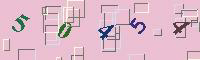

In [6]:
#看原始圖片
img = Image.open("./data/example.png")
img

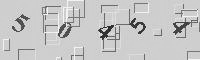

In [7]:
#轉灰階
img_L = img.convert("L")
img_L

In [8]:
#前處理
def img_preprocess(img):
    img_L = img.convert("L")     #灰階
    img_np = np.array(img_L)
    img_np = img_np.transpose()  #旋轉，方便做rnn
    img_np = img_np/255.0        #標準化
    return(img_np)

#### read img data

In [9]:
## 讀取圖檔&前處理
x_data = np.stack([img_preprocess(Image.open("./data/" + str(i) + ".png")) for i in df['id']])
x_data = x_data.reshape(x_data.shape+(1,))
print("Shape of img data:", x_data.shape)

Shape of img data: (31198, 200, 60, 1)


#### LabelEncoder & one_hot encoding

In [10]:
y_set = set(''.join(df['y']))
vocab_size = len(y_set)
le = LabelEncoder()
le.fit(list(y_set))
print('vocab_size:', vocab_size)
le.classes_

vocab_size: 35


array(['#', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q',
       'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], dtype='<U1')

In [11]:
y_data_le = df['y'].apply(lambda x: le.transform(list(x)))
y_data = np.stack([to_categorical(y, vocab_size) for y in y_data_le])
y_data.shape

(31198, 6, 35)

## train test split

In [12]:
x_train, x_test, y_train, y_test, df_train, df_test = train_test_split(x_data, y_data, df, test_size=0.2, random_state=1234)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, df_train.shape, df_test.shape)

(24958, 200, 60, 1) (24958, 6, 35) (6240, 200, 60, 1) (6240, 6, 35) (24958, 4) (6240, 4)


# training & testing

In [13]:
input_shape = x_train[0].shape
maxlen = np.max(df['len'])
vocab_size = len(le.classes_)

In [14]:
def get_model(input_shape, maxlen, vocab_size):
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=input_shape, activation='relu', border_mode='valid'),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),  
        Dropout(0.25),
    
        Conv2D(64, (3, 3), activation='relu', border_mode='valid'),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Dropout(0.25),
    
        Conv2D(128, (3, 3), activation='relu', border_mode='valid'),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(256),
        RepeatVector(maxlen),
        Bidirectional(GRU(output_dim=256, return_sequences=True)),
        TimeDistributed(Dense(vocab_size, activation='softmax')),
        ])
    return model

model = get_model(input_shape=input_shape, maxlen=maxlen, vocab_size=vocab_size)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/home/cxshe/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="valid", input_shape=(200, 60, ..., activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cxshe/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid", activation="relu")`
  if __name__ == '__main__':
/home/cxshe/.local/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="valid", activation="relu")`
  from ipykernel import kernelapp as app
/home/cxshe/.local/lib/python3.5/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(units=256, return_sequences=True)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 58, 32)       320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 56, 32)       9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 196, 56, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 28, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 26, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 94, 24, 64)        36928     
__________

In [15]:
def get_result(x, model):
    scores = model.predict(x)
    pred_le = [ [np.argmax(s) for s in score] for score in scores]
    pred_y = [''.join(p) for p in le.inverse_transform(pred_le)]
    return pred_y

def get_acc(x, y, model):
    pred_y = get_result(x, model)
    return accuracy_score(y, pred_y)
     
class EvaluateCallback(Callback):
    def __init__(self, x_tr, y_tr, x_te, y_te):
        self.x_tr = x_tr
        self.y_tr = y_tr
        self.x_te = x_te
        self.y_te = y_te
        self.tr_acc = []
        self.te_acc = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.tr_acc.append(get_acc(self.x_tr, self.y_tr, self.model))
        self.te_acc.append(get_acc(self.x_te, self.y_te, self.model))

In [16]:
epochs = 50
Evaluate = EvaluateCallback(x_train, df_train['y'], x_test, df_test['y'])
model.fit(x_train, y_train, batch_size=128, epochs=epochs, verbose=1,
          callbacks=[Evaluate]
         )

Epoch 1/50
24958/24958 [==============================] - 25s 984us/step - loss: 2.5356 - acc: 0.1756
Epoch 2/50
24958/24958 [==============================] - 22s 883us/step - loss: 2.3791 - acc: 0.2200
Epoch 3/50
24958/24958 [==============================] - 22s 883us/step - loss: 2.2548 - acc: 0.2727
Epoch 4/50
24958/24958 [==============================] - 22s 884us/step - loss: 1.8914 - acc: 0.4150
Epoch 5/50
24958/24958 [==============================] - 22s 883us/step - loss: 1.3305 - acc: 0.6029
Epoch 6/50
24958/24958 [==============================] - 22s 884us/step - loss: 0.8435 - acc: 0.7722
Epoch 7/50
24958/24958 [==============================] - 22s 883us/step - loss: 0.4986 - acc: 0.8776
Epoch 8/50
24958/24958 [==============================] - 22s 883us/step - loss: 0.3104 - acc: 0.9264
Epoch 9/50
24958/24958 [==============================] - 22s 884us/step - loss: 0.2143 - acc: 0.9503
Epoch 10/50
24958/24958 [==============================] - 22s 883us/step - loss: 

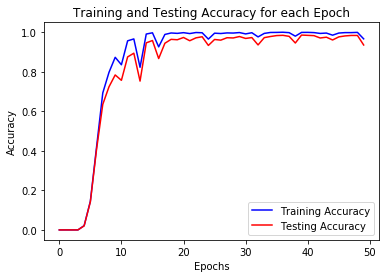

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.arange(0,epochs,1), Evaluate.tr_acc, 'b', label='Training Accuracy')
plt.plot(np.arange(0,epochs,1), Evaluate.te_acc, 'r', label='Testing Accuracy')

plt.title('Training and Testing Accuracy for each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 觀察訓練和測試的結果：
#### 1.大約收斂在20個epoch
#### 2.訓練和測試的準確度相關性高，且未出現overfitting，可以選擇training準確度較高的模型

In [18]:
max(Evaluate.tr_acc)

0.999879798060742

## training (all data)

In [19]:
input_shape = x_data[0].shape
maxlen = np.max(df['len'])
vocab_size = len(le.classes_)

model = get_model(input_shape=input_shape, maxlen=maxlen, vocab_size=vocab_size)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/home/cxshe/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="valid", input_shape=(200, 60, ..., activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cxshe/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid", activation="relu")`
  if __name__ == '__main__':
/home/cxshe/.local/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="valid", activation="relu")`
  from ipykernel import kernelapp as app
/home/cxshe/.local/lib/python3.5/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(units=256, return_sequences=True)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 198, 58, 32)       320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 196, 56, 32)       9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 196, 56, 32)       128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 98, 28, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 98, 28, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 96, 26, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 94, 24, 64)        36928     
__________

In [22]:
def get_result(x, model):
    scores = model.predict(x)
    pred_le = [ [np.argmax(s) for s in score] for score in scores]
    pred_y = [''.join(p) for p in le.inverse_transform(pred_le)]
    return pred_y

def get_acc(x, y, model):
    pred_y = get_result(x, model)
    return accuracy_score(y, pred_y)
     

class EvaluateCallback(Callback):
    def __init__(self, x_tr, y_tr):
        self.x_tr = x_tr
        self.y_tr = y_tr
        self.tr_acc = []
    
    def on_epoch_end(self, epoch, logs={}):
        current_acc = get_acc(self.x_tr, self.y_tr, self.model)
        self.tr_acc.append(current_acc)
        #選擇準確率0.995以上，並紀錄epoch
        if current_acc > 0.995:
            model.save('{}_{}.h5'.format(model_name, epoch))

In [23]:
epochs = 50
Evaluate = EvaluateCallback(x_data, df['y'])
model.fit(x_data, y_data, batch_size=128, epochs=epochs, verbose=1,
          callbacks=[Evaluate]
         )

Epoch 1/50
31198/31198 [==============================] - 28s 896us/step - loss: 2.4876 - acc: 0.1876
Epoch 2/50
31198/31198 [==============================] - 27s 857us/step - loss: 2.3160 - acc: 0.2444
Epoch 3/50
31198/31198 [==============================] - 27s 857us/step - loss: 1.9211 - acc: 0.4033
Epoch 4/50
31198/31198 [==============================] - 27s 858us/step - loss: 1.2375 - acc: 0.6341
Epoch 5/50
31198/31198 [==============================] - 27s 858us/step - loss: 0.6404 - acc: 0.8384
Epoch 6/50
31198/31198 [==============================] - 27s 859us/step - loss: 0.3477 - acc: 0.9160
Epoch 7/50
31198/31198 [==============================] - 27s 858us/step - loss: 0.2145 - acc: 0.9490
Epoch 8/50
31198/31198 [==============================] - 27s 858us/step - loss: 0.1434 - acc: 0.9686
Epoch 9/50
31198/31198 [==============================] - 27s 858us/step - loss: 0.0948 - acc: 0.9820
Epoch 10/50
31198/31198 [==============================] - 27s 859us/step - loss: 

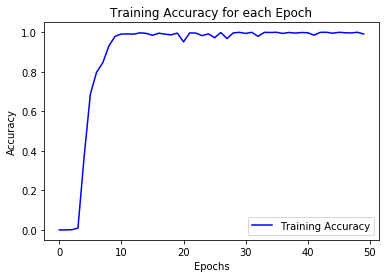

In [24]:
%matplotlib inline
plt.plot(np.arange(0,epochs,1), Evaluate.tr_acc, 'b', label='Training Accuracy')
plt.title('Training Accuracy for each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
from sklearn.externals import joblib
label_encoder = {
    "le": le,
}
joblib.dump(label_encoder, model_name.replace('model_', 'label_encoder_'))

['./model/label_encoder_cnn_rnn']